In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, classification_report, roc_curve)

from sklearn.ensemble import (RandomForestClassifier, BaggingClassifier, 
                              GradientBoostingClassifier, AdaBoostClassifier)
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE

from sklearn.pipeline import Pipeline


In [39]:
# Load train and test data
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

# Display the first few rows
df_train.head()
df_test.head()

,Employee ID,Age,Gender,Years at Company,Job Role,Monthly Income,Work-Life Balance,Job Satisfaction,Performance Rating,Number of Promotions,...,Number of Dependents,Job Level,Company Size,Company Tenure,Remote Work,Leadership Opportunities,Innovation Opportunities,Company Reputation,Employee Recognition,Attrition
0,52685,36,Male,13,Healthcare,8029,Excellent,High,Average,1,...,1,Mid,Large,22,No,No,No,Poor,Medium,Stayed
1,30585,35,Male,7,Education,4563,Good,High,Average,1,...,4,Entry,Medium,27,No,No,No,Good,High,Left
2,54656,50,Male,7,Education,5583,Fair,High,Average,3,...,2,Senior,Medium,76,No,No,Yes,Good,Low,Stayed
3,33442,58,Male,44,Media,5525,Fair,Very High,High,0,...,4,Entry,Medium,96,No,No,No,Poor,Low,Left
4,15667,39,Male,24,Education,4604,Good,High,Average,0,...,6,Mid,Large,45,Yes,No,No,Good,High,Stayed


# EDA (Exploratory Data ANalysis)

        Employee ID           Age  Years at Company  Monthly Income  \
count  14900.000000  14900.000000      14900.000000    14900.000000   
mean   37339.022081     38.385235         15.592416     7287.306040   
std    21453.129293     12.097904         11.133792     2156.737934   
min        5.000000     18.000000          1.000000     1226.000000   
25%    18825.500000     28.000000          7.000000     5633.750000   
50%    37433.000000     38.000000         13.000000     7332.000000   
75%    55857.500000     49.000000         23.000000     8852.000000   
max    74471.000000     59.000000         51.000000    15063.000000   

       Number of Promotions  Distance from Home  Number of Dependents  \
count          14900.000000        14900.000000          14900.000000   
mean               0.834362           49.927315              1.659329   
std                0.996511           28.702307              1.545401   
min                0.000000            1.000000              0.00000

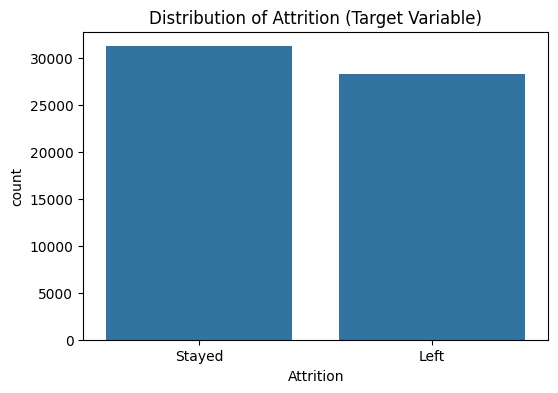

In [40]:
print(df_test.describe())
print(df_train.describe())

# Check for missing values
print(df_train.isnull().sum())
print(df_test.isnull().sum())

# Visualize the distribution of the target variable (Attrition)
plt.figure(figsize=(6, 4))
sns.countplot(x='Attrition', data=df_train)
plt.title('Distribution of Attrition (Target Variable)')
plt.show()

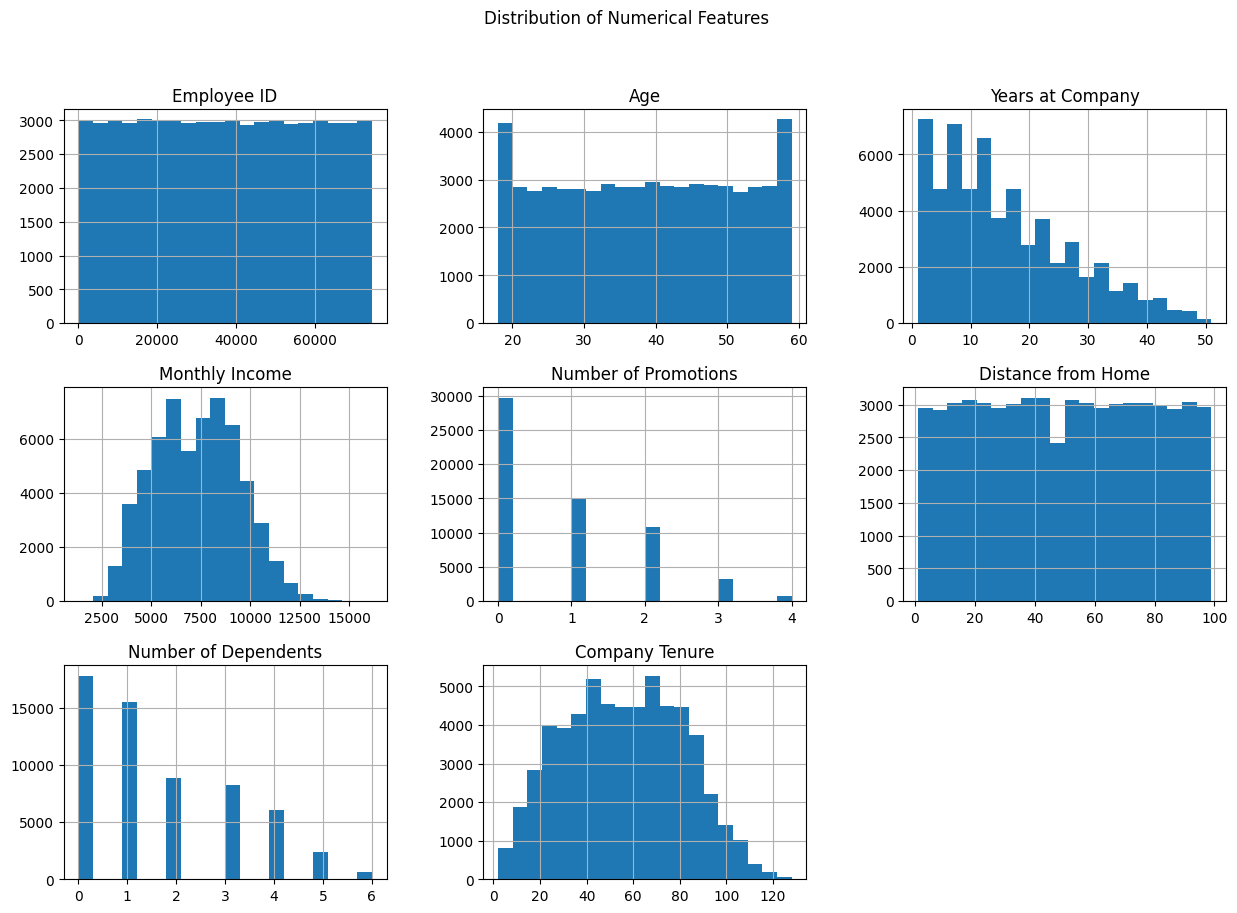

In [41]:
numerical_features = df_train.select_dtypes(include=[np.number]).columns
df_train[numerical_features].hist(bins=20, figsize=(15, 10))
plt.suptitle('Distribution of Numerical Features')
plt.show()

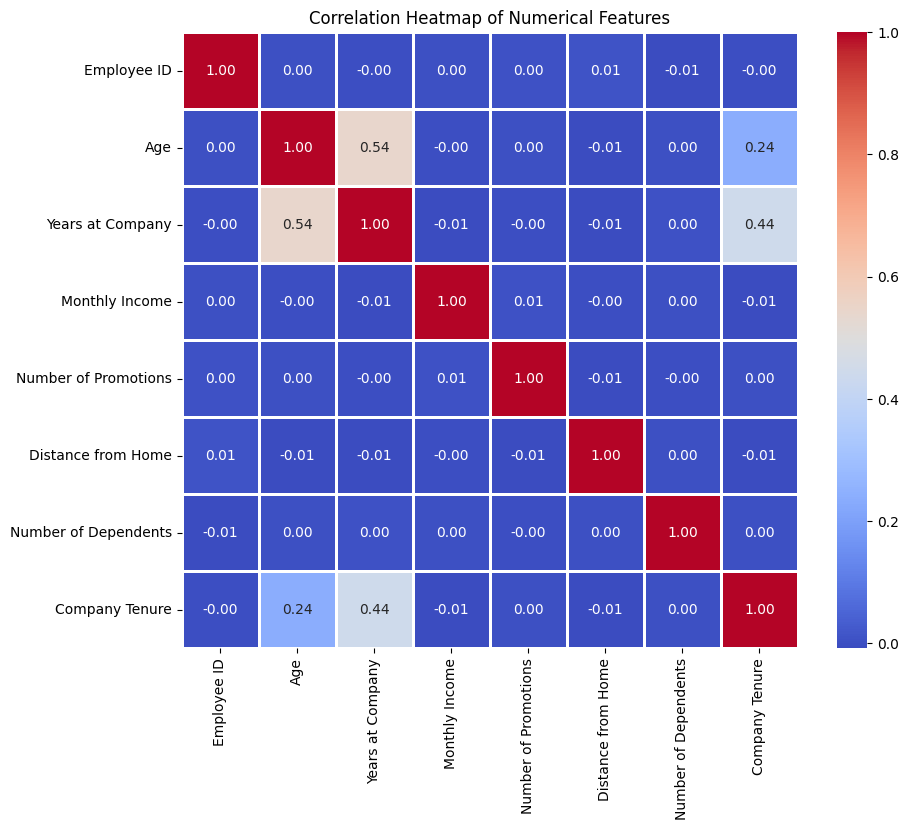

In [42]:
plt.figure(figsize=(10, 8))
corr_matrix = df_train[numerical_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=1, square=True)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

In [43]:
print(df_train.columns)

Index(['Employee ID', 'Age', 'Gender', 'Years at Company', 'Job Role',
       'Monthly Income', 'Work-Life Balance', 'Job Satisfaction',
       'Performance Rating', 'Number of Promotions', 'Overtime',
       'Distance from Home', 'Education Level', 'Marital Status',
       'Number of Dependents', 'Job Level', 'Company Size', 'Company Tenure',
       'Remote Work', 'Leadership Opportunities', 'Innovation Opportunities',
       'Company Reputation', 'Employee Recognition', 'Attrition'],
      dtype='object')


# Preprocessing
## Handle Missing Values

In [44]:
# Automatically identify categorical and numerical columns
cat_cols_train = df_train.select_dtypes(include=['object']).columns
num_cols_train = df_train.select_dtypes(include=['int64', 'float64']).columns

df_train[num_cols_train] = df_train[num_cols_train].fillna(df_train[num_cols_train].median())
for col in cat_cols_train:
    df_train[col] = df_train[col].fillna(df_train[col].mode()[0])

df_test[num_cols_train] = df_test[num_cols_train].fillna(df_train[num_cols_train].median())
for col in cat_cols_train:
    df_test[col] = df_test[col].fillna(df_train[col].mode()[0])

# One-hot encode categorical columns
df_train_encoded = pd.get_dummies(df_train, columns=cat_cols_train, drop_first=True)
df_test_encoded = pd.get_dummies(df_test, columns=cat_cols_train, drop_first=True)
    
# Reindex test set to match train set
df_test_encoded = df_test_encoded.reindex(columns=df_train_encoded.columns, fill_value=0)

In [45]:
# Scale numerical features (excluding the target column "Attrition")
num_cols_encoded = [col for col in df_train_encoded.columns if df_train_encoded[col].dtype in ["int64", "float64"] and col != "Attrition"]
scaler = StandardScaler()
df_train_encoded[num_cols_encoded] = scaler.fit_transform(df_train_encoded[num_cols_encoded])
df_test_encoded[num_cols_encoded] = scaler.transform(df_test_encoded[num_cols_encoded])

df_train_encoded.head()
df_test_encoded.head()

,Employee ID,Age,Years at Company,Monthly Income,Number of Promotions,Distance from Home,Number of Dependents,Company Tenure,Gender_Male,Job Role_Finance,...,Remote Work_Yes,Leadership Opportunities_Yes,Innovation Opportunities_Yes,Company Reputation_Fair,Company Reputation_Good,Company Reputation_Poor,Employee Recognition_Low,Employee Recognition_Medium,Employee Recognition_Very High,Attrition_Stayed
0,0.718337,-0.212414,-0.244881,0.337728,0.168266,1.159000,-0.416588,-1.328503,True,False,...,False,False,False,False,False,True,False,True,False,True
1,-0.308663,-0.295199,-0.778409,-1.273286,0.168266,0.175378,1.511835,-1.131736,True,False,...,False,False,False,False,True,False,False,False,False,False
2,0.809931,0.946567,-0.778409,-0.799185,2.178351,-1.264926,0.226220,0.796572,True,False,...,False,False,True,False,True,False,True,False,False,True
3,-0.175897,1.608842,2.511683,-0.826144,-0.836777,-0.246174,1.511835,1.583636,True,False,...,False,False,False,False,False,True,True,False,False,False
4,-1.001912,0.035939,0.733255,-1.254229,-0.836777,-0.105657,2.797450,-0.423378,True,False,...,True,False,False,False,True,False,False,False,False,True


In [46]:
# Separate features and target
X_train = df_train_encoded.drop('Attrition_Stayed', axis=1)
y_train = df_train_encoded["Attrition_Stayed"]
X_test = df_test_encoded.drop("Attrition_Stayed", axis=1)
y_test = df_test_encoded["Attrition_Stayed"]

# Model Training and Evaluation

In [47]:
# Oversample the training data using SMOTE
smote = SMOTE(random_state=42, sampling_strategy=1.0)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Calculate scale_pos_weight from original training data
counter_train = Counter(y_train)
scale_pos_weight = counter_train[0] / counter_train[1]

# Initialize models
models = {
    "Random Forest": RandomForestClassifier(random_state=42, class_weight={0:1, 1:10}),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42, scale_pos_weight=scale_pos_weight)
}

In [48]:
# Hyperparameter tuning for XGBoost
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'min_child_weight': [1, 5, 10],
    'gamma': [0, 0.1, 0.5],
    'scale_pos_weight': [scale_pos_weight, scale_pos_weight * 2]
}
xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
grid_search = GridSearchCV(xgb, param_grid, scoring='f1', cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train_res, y_train_res)
print("Best parameters for XGBoost:", grid_search.best_params_)
models["XGBoost"] = grid_search.best_estimator_

Fitting 3 folds for each of 1296 candidates, totalling 3888 fits


c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:53:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters for XGBoost: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'scale_pos_weight': 1.8130518234165067, 'subsample': 0.8}


In [49]:
# Evaluation function
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    print(f"----- {name} -----")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred, zero_division=0))
    print("Recall:", recall_score(y_test, y_pred, zero_division=0))
    print("F1 Score:", f1_score(y_test, y_pred, zero_division=0))
    if y_pred_prob is not None:
        print("ROC-AUC:", roc_auc_score(y_test, y_pred_prob))
    print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))
    print("\n")

for name, model in models.items():
    print(f"Training {name} with SMOTE resampled data...")
    model.fit(X_train_res, y_train_res)
    evaluate_model(name, model, X_test, y_test)

Training Random Forest with SMOTE resampled data...
----- Random Forest -----
Accuracy: 0.74248322147651
Precision: 0.7906272530641673
Recall: 0.6968734112862227
F1 Score: 0.740795784638249
ROC-AUC: 0.8346269240968587

Classification Report:
               precision    recall  f1-score   support

       False       0.70      0.79      0.74      7032
        True       0.79      0.70      0.74      7868

    accuracy                           0.74     14900
   macro avg       0.75      0.75      0.74     14900
weighted avg       0.75      0.74      0.74     14900



Training Gradient Boosting with SMOTE resampled data...
----- Gradient Boosting -----
Accuracy: 0.7575838926174496
Precision: 0.779485158917783
Recall: 0.7543213014743264
F1 Score: 0.766696809197778
ROC-AUC: 0.8505986396416874

Classification Report:
               precision    recall  f1-score   support

       False       0.73      0.76      0.75      7032
        True       0.78      0.75      0.77      7868

    accuracy

c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:54:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


----- XGBoost -----
Accuracy: 0.7474496644295302
Precision: 0.7138689173700115
Recall: 0.8707422470767666
F1 Score: 0.7845405095906098
ROC-AUC: 0.852363395195932

Classification Report:
               precision    recall  f1-score   support

       False       0.81      0.61      0.69      7032
        True       0.71      0.87      0.78      7868

    accuracy                           0.75     14900
   macro avg       0.76      0.74      0.74     14900
weighted avg       0.76      0.75      0.74     14900



